In [1]:
## detect speaker using deep learning
## venv\Scripts\activate (active venv)

In [2]:
import os
import shutil
import numpy as np
import tensorflow as tf
import keras
from pathlib import Path
from IPython.display import display, Audio
import subprocess

In [3]:
DATASET_ROOT = "16000_pcm_speeches"

# The folders in which we will put the audio samples and the noise samples
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

# Percentage of samples to use for validation
VALID_SPLIT = 0.1

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all the audio samples.
# We will resample all the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 1

In [4]:
DATASET_AUDIO_PATH

'16000_pcm_speeches\\audio'

In [5]:
DATASET_NOISE_PATH

'16000_pcm_speeches\\noise'

In [6]:
voice_file_names = os.listdir(DATASET_AUDIO_PATH)

In [7]:
voice_file_names

['Benjamin_Netanyau',
 'Jens_Stoltenberg',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela']

In [8]:
voice_file_names_2 = os.listdir(DATASET_NOISE_PATH)

In [9]:
voice_file_names_2

['other', '_background_noise_']

In [10]:
voice_files_count = []

In [11]:
for t in voice_file_names:
    p = os.listdir("16000_pcm_speeches/audio" + "/" + t)
    len_class = len(p)
    voice_files_count.append(len_class)

In [12]:
voice_files_count

[1500, 1500, 1501, 1500, 1500]

In [13]:
voice_files_count_2 = []

In [14]:
for t in voice_file_names_2:
    p = os.listdir("16000_pcm_speeches/noise" + "/" + t)
    len_class = len(p)
    voice_files_count_2.append(len_class)

In [15]:
voice_files_count_2

[2, 4]

In [16]:
import plotly.express as px
import numpy

random_x = voice_file_names
random_y = voice_files_count

fig = px.bar(random_x, y=random_y)
fig.show()

In [17]:
import plotly.express as px
import numpy

random_x = voice_file_names_2
random_y = voice_files_count_2

fig = px.bar(random_x, y=random_y)
fig.show()

In [18]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]
if not noise_paths:
    raise RuntimeError(f"Could not find any files at {DATASET_NOISE_PATH}")
print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


In [19]:
noise_paths

['16000_pcm_speeches\\noise\\other\\exercise_bike.wav',
 '16000_pcm_speeches\\noise\\other\\pink_noise.wav',
 '16000_pcm_speeches\\noise\\_background_noise_\\10convert.com_Audience-Claps_daSG5fwdA7o.wav',
 '16000_pcm_speeches\\noise\\_background_noise_\\doing_the_dishes.wav',
 '16000_pcm_speeches\\noise\\_background_noise_\\dude_miaowing.wav',
 '16000_pcm_speeches\\noise\\_background_noise_\\running_tap.wav']

In [20]:
import librosa
x, sr = librosa.load("16000_pcm_speeches/noise/other/exercise_bike.wav")

In [21]:
print(x.shape)
print(sr)

(1350650,)
22050


In [22]:
import matplotlib.pyplot as plt
import librosa.display

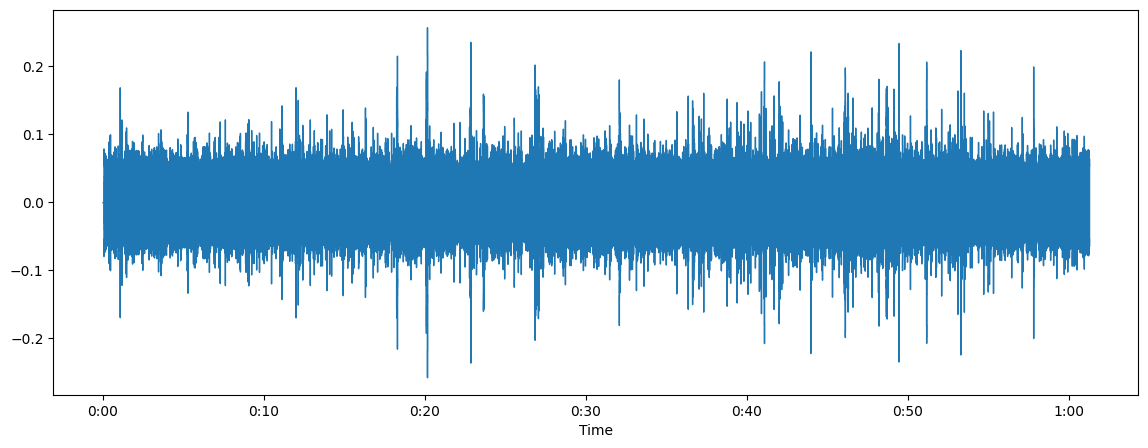

In [23]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

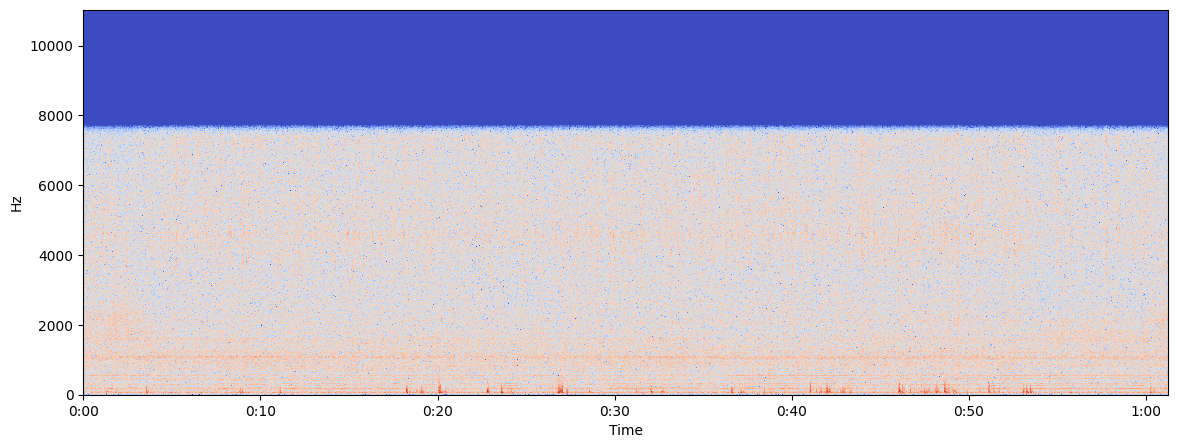

In [24]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [25]:
import IPython.display as ipd
ipd.Audio("16000_pcm_speeches/noise/other/exercise_bike.wav")

In [26]:

# Split noise into chunks of 16,000 steps each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    print("sampling rate of original audio", sampling_rate)
    if sampling_rate == SAMPLING_RATE:
        print("shape", sample.shape[0])
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for", path, "is incorrect")
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 980063
sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 960000
sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 260686
sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 1522931
sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 988892
sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 978489


In [27]:
noises

<tf.Tensor: shape=(354, 16000, 1), dtype=float32, numpy=
array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.00689697],
        [ 0.00790405],
        [ 0.03509521]],

       [[ 0.02261353],
        [ 0.02304077],
        [ 0.03662109],
        ...,
        [ 0.04656982],
        [ 0.01574707],
        [-0.0055542 ]],

       [[ 0.0269165 ],
        [ 0.00112915],
        [-0.0249939 ],
        ...,
        [ 0.02557373],
        [ 0.009552  ],
        [ 0.02032471]],

       ...,

       [[-0.17367554],
        [-0.01434326],
        [ 0.0116272 ],
        ...,
        [-0.03067017],
        [-0.07922363],
        [-0.06228638]],

       [[ 0.04049683],
        [ 0.01351929],
        [-0.05047607],
        ...,
        [-0.1126709 ],
        [-0.06536865],
        [ 0.08911133]],

       [[-0.06359863],
        [ 0.03466797],
        [ 0.01138306],
        ...,
        [ 0.00582886],
        [-0.07492065],
        [ 0.10736084]]], dtype=float3

## DATASET GENERATION

In [28]:
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(
        lambda x: path_to_audio(x), num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):

    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

class_names = os.listdir(DATASET_AUDIO_PATH)
print(
    "Our class names: {}".format(
        class_names,
    )
)

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print(
        "Processing speaker {}".format(
            name,
        )
    )
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']
Processing speaker Benjamin_Netanyau
Processing speaker Jens_Stoltenberg
Processing speaker Julia_Gillard
Processing speaker Magaret_Tarcher
Processing speaker Nelson_Mandela
Found 7501 files belonging to 5 classes.
Using 6751 files for training.
Using 750 files for validation.


## MODEL DEFINITION

In [29]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.keras"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 8000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 8000, 16)  │         64 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 8000, 16)  │          0 │ conv1d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 8000, 16)  │        784 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8000, 16)  │         32 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8000, 16)  │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 8000, 16)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 4000, 16)  │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 4000, 32)  │      1,568 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 4000, 32)  │          0 │ conv1d_4[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 4000, 32)  │      3,104 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 4000, 32)  │        544 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4000, 32)  │          0 │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 4000, 32)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 2000, 32)  │          0 │ activation_3[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 2000, 64)  │      6,208 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 2000, 64)  │          0 │ conv1d_7[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 2000, 64)  │     12,352 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 2000, 64)  │          0 │ conv1d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 2000, 64)  │     12,352 │ activation_5[0][

 Total params: 3,088,597 (11.78 MB)

 Trainable params: 3,088,597 (11.78 MB)

 Non-trainable params: 0 (0.00 B)

## TRAINING

In [30]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

53/53 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5105 - loss: 1.9645 - val_accuracy: 0.8427 - val_loss: 0.3869


## EVALUATION

In [31]:
print(model.evaluate(valid_ds))


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.8516 - loss: 0.3765
[0.38687413930892944, 0.8426666855812073]


## DEMONSTRATION
Lấy thử 1 người nói:
- Cho nó dự đoán người nói là ai
- So sánh dự đoán với lại người nói có khớp không
- Nghe âm thanh để thấy rằng mặc dù các mẫu có nhiễu, mô hình vẫn khá chính xác

In [34]:
SAMPLES_TO_DISPLAY = 1

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
